# Library Data Analysis: Part 2

Author: Andrea Mock

After having explored the library books dataset, we can look at another dataset that contains information about the most popular books that were borrowed each week throughout 2020. 

The notebook is broken down into the following sections: <br/>
[1. Importing libraries and data](#intro)<br/>
[2. Examining temporal trends in borrowing](#borrow_hist)<br/>
[3. Merging datasets](#merge)<br/>
[4. Hypothesis testing](#ttest)<br/>
[5. Suggestions to the library administrators](#feedback)<br/>

<a id="intro"></a>
## 1. Importing data and libraries
To begin we import the two datasets that are part of this project: 
- the overview of all books in our library
- the borrowing trends for the top books in 2020

In [1]:
from collections import Counter
import json
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [36]:
# import dataset that contains all library books info 
books_df = pd.read_csv('all_books.csv', index_col=0)
books_df.head()

,isbn,title,author,publication_year,publisher,image_url_s,image_url_m,image_url_l,copies,available,ratio,decade
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0,0.000000,2000
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,2,0,0.000000,2000
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,9,7,0.777778,1990
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,1,0,0.000000,1990
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,7,4,0.571429,1990


In [5]:
# create a dataframe that contains historical book data  
topBooks = pd.read_json('cscl_2020_top_hundred_books.json',lines=True)
topBooks.head()

,week,isbn,count
0,1,195153448,93
1,1,887841740,100
2,1,971880107,25
3,1,375759778,21
4,1,3404921038,88


In [6]:
# convert values to ints from string
topBooks['count'] = topBooks['count'].apply(lambda x:int(x))
topBooks['week'] = topBooks['week'].apply(lambda x:int(x))

<a id="borrow_hist"></a>
## 2. Examining lending history 
Our topBooks dataframe contains the isbn of a particular book as well as the number of times that book title was borrowed in each week. Since our dataset contains more than 5000 entries we first want to see how many unique books (isbn) are in the dataset. As we can see there are 106 unique books that appear in the topBooks dataframe, meaning that for 106 books we have borrowing history for a whole year. 

In [7]:
# check out distribution of titles included each week 
topBooks.groupby(by=["week"])['isbn'].count().unique()

array([106])

### 2.1 Borrowing frequency by book 
By grouping the books by isbn we can create a dataframe that includes the total number of times a book was borrowed throughout the year. In addition we can focus on the top 10 books and create a graphical representation of their borrowing history throughout the year.

In [8]:
# create dataframe that counts total number of times a book was borrowed
bookFreq = pd.DataFrame(topBooks.groupby(by=["isbn"])['count'].sum())
bookFreq = bookFreq.reset_index().sort_values('count', ascending=False).reset_index(drop=True)

In [9]:
# example of books and number of times they were borrowed
bookFreq.head()

,isbn,count
0,345465083,3440
1,618119760,3419
2,446612545,3270
3,385509456,3238
4,385495145,3221


Now we can extract the top books and filter to only include the temporal data for those ten books.

In [13]:
# grab the top 10 books checked out in 2020
top10 = bookFreq.head(10)
top10

,isbn,count
0,345465083,3440
1,618119760,3419
2,446612545,3270
3,385509456,3238
4,385495145,3221
5,425182908,3219
6,312995423,3192
7,042518630X,3188
8,749748001,3187
9,743470389,3176


In [14]:
# gather the isbn of the top 10 books to use as filter
topIsbns = top10['isbn'].to_list()
topIsbns

['345465083',
 '618119760',
 '446612545',
 '385509456',
 '385495145',
 '425182908',
 '312995423',
 '042518630X',
 '749748001',
 '743470389']

In [12]:
def extractTopBooks(entry, isbnList):
    """
    returns true if a book entry's isbn is in a list of isbn, otherwise false
    """
    return (entry['isbn'] in isbnList)

In [15]:
# filtered dataframe with only information about top 10 books
top10Info = topBooks[topBooks.apply(lambda x: extractTopBooks(x, topIsbns), axis=1)]
top10Info.head()

,week,isbn,count
6,1,425182908,21
7,1,042518630X,36
12,1,345465083,38
19,1,446612545,18
44,1,385509456,43


In [149]:
# visualize borrowing trends for top 10 books
import plotly.express as px
fig = px.area(top10Info, x="week", y="count", color="isbn", line_group="isbn", title= "borrowing trends for top 10 books")
fig.show()

In [17]:
# borrowing trends for one book, here the book with most total borrowings
fig = px.line(top10Info[top10Info['isbn'] == '425182908'], x="week", y="count", color="isbn")
fig.show()

### 2.2 Borrowing frequency by week
Next we can also look at the number of books borrowed per week:

In [18]:
# extract number of books borrowed each week
weekOverview = topBooks.groupby(by=["week"])['count'].sum()
weekOverview[:3]

week
1    6151
2    5838
3    5727
Name: count, dtype: int64

In [19]:
# summary statistics of borrowings per week
weekOverview.describe()

count      52.000000
mean     5964.403846
std       224.758542
min      5484.000000
25%      5830.500000
50%      5969.500000
75%      6105.750000
max      6424.000000
Name: count, dtype: float64

Text(0, 0.5, 'number of books')

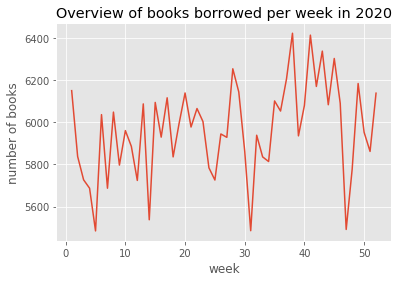

In [20]:
# overview of books borrowed per week for top books
ax = weekOverview.plot(title='Overview of books borrowed per week in 2020')
ax.set_ylabel("number of books")

<a id='merge'></a>
## 3. Merging datasets 
Although our dataset with the information on the books that have been borrowed the most we only have information about their isbn and not much more. By merging the temporal borrowing information with the dataset containing information on all books in our library we can obtain a more complete picture of what books we are dealing with. 

In [21]:
def getUniqueIsbns(df):
    """
    returns a list of unique isbns contained in the given dataframe 
    """
    isbns = df['isbn'].unique()
    isbnList = []
    for isbn in isbns:
        if len(isbn) < 10:
            zerosNeeded = 10 - len(isbn)
            isbn = '0'*zerosNeeded + isbn # add zeros in the front to get the isbn10
        isbnList.append(isbn)
    return isbnList

In [22]:
# preprocess isbns for merging
uniqueIsbns = getUniqueIsbns(bookFreq)
uniqueIsbns[:5]

['0345465083', '0618119760', '0446612545', '0385509456', '0385495145']

In [23]:
# check if all isbns were processed
len(uniqueIsbns)

106

In [24]:
# Create a dataframe copy and update the cleaned isbns 
bookFreq_clean = bookFreq.copy()
bookFreq_clean['isbn'] = uniqueIsbns

In [38]:
# merge dataset 
popBooks = pd.merge(bookFreq_clean, books_df, on="isbn")
popBooks.head()

,isbn,count,title,author,publication_year,publisher,image_url_s,image_url_m,image_url_l,copies,available,ratio,decade
0,0345465083,3440,Seabiscuit,LAURA HILLENBRAND,2003,Ballantine Books,http://images.amazon.com/images/P/0345465083.0...,http://images.amazon.com/images/P/0345465083.0...,http://images.amazon.com/images/P/0345465083.0...,2,0,0.000000,2000
1,0618119760,3419,The Saints of Big Harbour: A Novel,Lynn Coady,2002,Houghton Mifflin Company,http://images.amazon.com/images/P/0618119760.0...,http://images.amazon.com/images/P/0618119760.0...,http://images.amazon.com/images/P/0618119760.0...,6,1,0.166667,2000
2,0446612545,3270,The Beach House,James Patterson,2003,Warner Books,http://images.amazon.com/images/P/0446612545.0...,http://images.amazon.com/images/P/0446612545.0...,http://images.amazon.com/images/P/0446612545.0...,1,0,0.000000,2000
3,0385509456,3238,The Curious Incident of the Dog in the Night-T...,MARK HADDON,2003,Doubleday,http://images.amazon.com/images/P/0385509456.0...,http://images.amazon.com/images/P/0385509456.0...,http://images.amazon.com/images/P/0385509456.0...,1,0,0.000000,2000
4,0385495145,3221,The Messenger,JOSEPH GIRZONE,2002,Image,http://images.amazon.com/images/P/0385495145.0...,http://images.amazon.com/images/P/0385495145.0...,http://images.amazon.com/images/P/0385495145.0...,2,1,0.500000,2000


In [39]:
# check if merged all books successfully
popBooks.shape

(106, 13)

In [40]:
# extract the top hundred books and save to dataframe
top100 = popBooks.sort_values('count', ascending=False)[:100]
most_read = top100.copy().reset_index(drop=True)
most_read = most_read.drop(['count'],axis=1) # drop count column to be able to compare to books dataframe
most_read.head()

,isbn,count,title,author,publication_year,publisher,image_url_s,image_url_m,image_url_l,copies,available,ratio,decade
0,0345465083,3440,Seabiscuit,LAURA HILLENBRAND,2003,Ballantine Books,http://images.amazon.com/images/P/0345465083.0...,http://images.amazon.com/images/P/0345465083.0...,http://images.amazon.com/images/P/0345465083.0...,2,0,0.000000,2000
1,0618119760,3419,The Saints of Big Harbour: A Novel,Lynn Coady,2002,Houghton Mifflin Company,http://images.amazon.com/images/P/0618119760.0...,http://images.amazon.com/images/P/0618119760.0...,http://images.amazon.com/images/P/0618119760.0...,6,1,0.166667,2000
2,0446612545,3270,The Beach House,James Patterson,2003,Warner Books,http://images.amazon.com/images/P/0446612545.0...,http://images.amazon.com/images/P/0446612545.0...,http://images.amazon.com/images/P/0446612545.0...,1,0,0.000000,2000
3,0385509456,3238,The Curious Incident of the Dog in the Night-T...,MARK HADDON,2003,Doubleday,http://images.amazon.com/images/P/0385509456.0...,http://images.amazon.com/images/P/0385509456.0...,http://images.amazon.com/images/P/0385509456.0...,1,0,0.000000,2000
4,0385495145,3221,The Messenger,JOSEPH GIRZONE,2002,Image,http://images.amazon.com/images/P/0385495145.0...,http://images.amazon.com/images/P/0385495145.0...,http://images.amazon.com/images/P/0385495145.0...,2,1,0.500000,2000


In [42]:
# extract all books that don't belong to top 100 list
bottom900 = pd.concat([books_df,most_read]).drop_duplicates(keep=False)
bottom900.head()

,isbn,title,author,publication_year,publisher,image_url_s,image_url_m,image_url_l,copies,available,ratio,decade
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,2,0,0.000000,2000
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,9,7,0.777778,1990
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,1,0,0.000000,1990
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,7,4,0.571429,1990
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,1,0,0.000000,1990


<a id='ttest'></a>
## 4. Hypothesis testing

Having broken down our datasets into two independent disjoint sets we can perform different hypothesis tests with regards to the books and the number of copies and other data contained in these datasets.


In [45]:
import scipy.stats as stats
from plotly.figure_factory import create_table

In [46]:
def performTTest(group1,group2,var=False):
    """
    performs a two sample t-test and returns the result
    """
    return stats.ttest_ind(group1, group2, 
                                nan_policy='omit', # omit nan values from the samples 
                                equal_var=var) # don't assume that variance is the same

In [47]:
def showTTestResults(ttest):
    """
    given the results of a two-sample t-test creates a table that shows the results of the test
    """
    matrix_twosample = [
    ['', 'Test Statistic', 'p-value'],
    ['Sample Data', ttest[0], ttest[1]/2]] 
    
    test_table = create_table(matrix_twosample, index=True)
    test_table.show()

### 4.1 Hypothesis test regarding book copies

**Null Hypothesis:** The average number of available copies for books in the top 100 books and bottomw 900 books is same.

**Alternative Hypothesis:** The number of copies available for books in the top 100 books is larger.

**Significance Level**: 95% (p-value needs to be smaller than 0.05 to reject the null hypothesis)

In [43]:
# summary statistics of book copies of bottom 900 books
bottom900['copies'].describe()

count    899.000000
mean       4.936596
std        2.585161
min        1.000000
25%        3.000000
50%        5.000000
75%        7.000000
max        9.000000
Name: copies, dtype: float64

In [44]:
# summary statistics of book copies of top 100 books
top100['copies'].describe()

count    100.000000
mean       4.920000
std        2.751235
min        1.000000
25%        2.000000
50%        5.000000
75%        8.000000
max        9.000000
Name: copies, dtype: float64

In [49]:
# t-test of average number of copies of books 
showTTestResults(performTTest(top100['copies'],bottom900['copies']))

### 4.2 Hypothesis test regarding availability ratio 

**Null Hypothesis:** The average book ratio for books published in the top 100 and bottom 900 books datasets is the same.

**Alternative Hypothesis:** The book ratio value for books published in the top 100s larger.

**Significance Level**: 95% (p-value needs to be smaller than 0.05 to reject the null hypothesis)

In [48]:
showTTestResults(performTTest(top100['ratio'],bottom900['ratio']))

In neither case of looking at the ratio as well as the number of copies of books available did we find a significant difference in the average copies and copy to available copies ratio.

### 4.3 Examining authors 

Now that we have a merged dataset we can extract the names of the authors of the most popular books and compare those to the bottom 900 books and the authors of these books. 

In [50]:
# authors and number of times they appear in top 100 books
top100['author'].value_counts()

James Patterson         3
Terry Pratchett         2
LAURA HILLENBRAND       2
John Grisham            2
Enid Blyton             2
                       ..
ARTHUR PHILLIPS         1
Stuart Woods            1
Richard Russo           1
Jonathan Safran Foer    1
Sheila Heti             1
Name: author, Length: 91, dtype: int64

In [150]:
# authors and number of times they appear in bottom 900 books
bottom900['author'].value_counts()

Ray Bradbury          11
Mary Higgins Clark     9
John Grisham           9
PHILIP PULLMAN         7
Douglas Adams          6
                      ..
Willa Cather           1
Dan Quayle             1
Nicola Griffith        1
Sandra Levy Ceren      1
LEE SMITH              1
Name: author, Length: 702, dtype: int64

If we look at the top authors listed in both groups, and see that the top ones are different, this cannot be interpreted as a sign that there is a significant difference in which authors are popular. Instead the books part of the top 100 list are from a wide array of different authors and are not clustered around a handful of authors.

<a id="feedback"></a>
## 5. Suggestions to the library administrators

Although we have determined which books are in the group of most borrowed books, but we are also asked to make a recommendation of how many more copies of each particular book are need as well as which books should be removed from the library. 

### 5.1 Examining top books borrowing 
To calculate the need of additional books, lets again take a closer look at the number of total copies and available copies exist for the books that we know are part of the most popular books list.

In [53]:
top100.sort_values('copies')

,isbn,count,title,author,publication_year,publisher,image_url_s,image_url_m,image_url_l,copies,available,ratio,decade
90,0385511612,2720,Bleachers,John Grisham,2003,Doubleday,http://images.amazon.com/images/P/0385511612.0...,http://images.amazon.com/images/P/0385511612.0...,http://images.amazon.com/images/P/0385511612.0...,1,0,0.000000,2000
41,0375726403,2998,Empire Falls,Richard Russo,2002,Vintage Books USA,http://images.amazon.com/images/P/0375726403.0...,http://images.amazon.com/images/P/0375726403.0...,http://images.amazon.com/images/P/0375726403.0...,1,0,0.000000,2000
2,0446612545,3270,The Beach House,James Patterson,2003,Warner Books,http://images.amazon.com/images/P/0446612545.0...,http://images.amazon.com/images/P/0446612545.0...,http://images.amazon.com/images/P/0446612545.0...,1,0,0.000000,2000
3,0385509456,3238,The Curious Incident of the Dog in the Night-T...,MARK HADDON,2003,Doubleday,http://images.amazon.com/images/P/0385509456.0...,http://images.amazon.com/images/P/0385509456.0...,http://images.amazon.com/images/P/0385509456.0...,1,0,0.000000,2000
5,0425182908,3219,Isle of Dogs,Patricia Cornwell,2002,Berkley Publishing Group,http://images.amazon.com/images/P/0425182908.0...,http://images.amazon.com/images/P/0425182908.0...,http://images.amazon.com/images/P/0425182908.0...,1,0,0.000000,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0451208080,2925,The Short Forever,Stuart Woods,2003,Signet Book,http://images.amazon.com/images/P/0451208080.0...,http://images.amazon.com/images/P/0451208080.0...,http://images.amazon.com/images/P/0451208080.0...,9,4,0.444444,2000
65,0316666343,2845,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,9,5,0.555556,2000
73,0786015276,2832,11th Hour,Bradley Warshauer,2003,Pinnacle Books,http://images.amazon.com/images/P/0786015276.0...,http://images.amazon.com/images/P/0786015276.0...,http://images.amazon.com/images/P/0786015276.0...,9,2,0.222222,2000
59,0449005615,2909,Seabiscuit: An American Legend,LAURA HILLENBRAND,2002,Ballantine Books,http://images.amazon.com/images/P/0449005615.0...,http://images.amazon.com/images/P/0449005615.0...,http://images.amazon.com/images/P/0449005615.0...,9,6,0.666667,2000


To set up a formula for calculating the need for more copies for particular books, let's first take a closer look at the borrowing history for one of the top books. Here we take the first book listed in our dataframe, titled "Bleachers" by John Grisham. 

In [59]:
# examine borrowing history of a particular book over the year
topBooks[topBooks['isbn'] == '385511612'].head(10)

,week,isbn,count
45,1,385511612,10
151,2,385511612,23
257,3,385511612,54
363,4,385511612,72
469,5,385511612,27
575,6,385511612,23
681,7,385511612,15
787,8,385511612,71
893,9,385511612,92
999,10,385511612,54


In [60]:
# look at borrowing statistics for the year
topBooks[topBooks['isbn'] == '385511612']['count'].describe()

count    52.000000
mean     52.307692
std      27.878264
min      10.000000
25%      28.500000
50%      54.000000
75%      77.000000
max      94.000000
Name: count, dtype: float64

### 5.2 Developing a measure to determine extra need

If we take the mean number of times the book was borrowed per week by looking at the total number of borrowings divided by the number of weeks in a year (52 weeks) we get that the book was borrowed on average 52 times per week. That is a very large number (and also unrealistic) for a book where there is only one copy. 

If we assume that the numbers are indeed correct, this would mean that there would be 7 borrows for a that particular book per day (highly unlikely!). Most individuals might take at least a week for a book. But under the assumption that this libary is an outlier and the readers are in fact very fast and take only a day that would mean that there is a need for around seven more book copies of that particular book to meet demand. 

Using this reasoning we can then deduce a formula to calculate how many books are needed:
The result we want is that there is that the ratio of one borrow per copy per day for a given book title (at minimum).
First calculate the mean number of borrows per day. Then since for reasons of simplicity we assume that everyone using the library can finish a book within a day we want to have a book available to be borrowed at least once every day, then to achieve this ratio we take the average number of books borrowed on any given day and subtract the number of copies available to get the further quantity of books needed.

In [68]:
import math

In [111]:
def booksNeeded(numCopies,totalCount):
    """
    given the number of copies of a book that exist and the total number of books that were borrowed throughout 
    the years returns the number of additional books that need to be purchased to reach the ratio of having 
    a copy per customer per day 
    """
    daily_ratio = totalCount/52/7 # calculates on average how often a book gets borrowed per day
    additional_need = math.ceil(daily_ratio) - numCopies
    if (daily_ratio > 1) and additional_need >0: # since one is our cutoff
        return additional_need
    return 0 # no additional book copies needed

In [112]:
# save the number of additional copies needed in new column
top100['additional_need'] = top100.apply(lambda val: booksNeeded(val['copies'], val['count']), axis=1)

In [113]:
# summary statistics on how many additional books are needed
top100['additional_need'].describe()

count    100.000000
mean       3.770000
std        2.740843
min        0.000000
25%        1.000000
50%        4.000000
75%        6.000000
max        8.000000
Name: additional_need, dtype: float64

Text(0.5, 0, 'number of additional books')

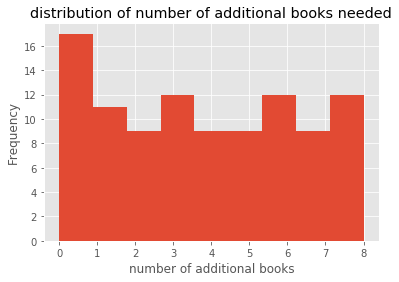

In [127]:
# visualize additional book needs
pl = top100['additional_need'].plot.hist(bins=len(top100['additional_need'].unique()), 
                                         title='distribution of number of additional books needed')
pl.set_xlabel("number of additional books")

In [130]:
# books where we need more copies 
top100[top100['additional_need'] > 0]

,isbn,count,title,author,publication_year,publisher,image_url_s,image_url_m,image_url_l,copies,available,ratio,decade,additional_need
0,0345465083,3440,Seabiscuit,LAURA HILLENBRAND,2003,Ballantine Books,http://images.amazon.com/images/P/0345465083.0...,http://images.amazon.com/images/P/0345465083.0...,http://images.amazon.com/images/P/0345465083.0...,2,0,0.000000,2000,8
1,0618119760,3419,The Saints of Big Harbour: A Novel,Lynn Coady,2002,Houghton Mifflin Company,http://images.amazon.com/images/P/0618119760.0...,http://images.amazon.com/images/P/0618119760.0...,http://images.amazon.com/images/P/0618119760.0...,6,1,0.166667,2000,4
2,0446612545,3270,The Beach House,James Patterson,2003,Warner Books,http://images.amazon.com/images/P/0446612545.0...,http://images.amazon.com/images/P/0446612545.0...,http://images.amazon.com/images/P/0446612545.0...,1,0,0.000000,2000,8
3,0385509456,3238,The Curious Incident of the Dog in the Night-T...,MARK HADDON,2003,Doubleday,http://images.amazon.com/images/P/0385509456.0...,http://images.amazon.com/images/P/0385509456.0...,http://images.amazon.com/images/P/0385509456.0...,1,0,0.000000,2000,8
4,0385495145,3221,The Messenger,JOSEPH GIRZONE,2002,Image,http://images.amazon.com/images/P/0385495145.0...,http://images.amazon.com/images/P/0385495145.0...,http://images.amazon.com/images/P/0385495145.0...,2,1,0.500000,2000,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0743418190,2682,In Her Shoes : A Novel,Jennifer Weiner,2002,Atria Books,http://images.amazon.com/images/P/0743418190.0...,http://images.amazon.com/images/P/0743418190.0...,http://images.amazon.com/images/P/0743418190.0...,5,1,0.200000,2000,3
96,0142001740,2679,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books,http://images.amazon.com/images/P/0142001740.0...,http://images.amazon.com/images/P/0142001740.0...,http://images.amazon.com/images/P/0142001740.0...,5,1,0.200000,2000,3
97,051513290X,2675,Summer of Storms,Judith Kelman,2002,Jove Books,http://images.amazon.com/images/P/051513290X.0...,http://images.amazon.com/images/P/051513290X.0...,http://images.amazon.com/images/P/051513290X.0...,3,2,0.666667,2000,5
98,0385508042,2663,The King of Torts,John Grisham,2003,Doubleday Books,http://images.amazon.com/images/P/0385508042.0...,http://images.amazon.com/images/P/0385508042.0...,http://images.amazon.com/images/P/0385508042.0...,1,0,0.000000,2000,7


In total there are thus 83 of the top 100 books of which we need additional copies. The column additional_copies details the exact need of how many copies are needed in addition to satisfy the demand according to the assumptions mentioned above.

## 5.3 Determing which books to remove
Next we also want to look at the worst 100 books. Now we have a list of books that do not belong to the 106 most popular books.

In [138]:
# extract the top 106 books
allTop = popBooks.sort_values('count', ascending=False)
most_readAll = allTop.copy().reset_index(drop=True)
most_readAll = most_readAll.drop(['count'],axis=1) # drop count column to be able to compare to books dataframe
most_readAll.head()

,isbn,title,author,publication_year,publisher,image_url_s,image_url_m,image_url_l,copies,available,ratio,decade
0,0345465083,Seabiscuit,LAURA HILLENBRAND,2003,Ballantine Books,http://images.amazon.com/images/P/0345465083.0...,http://images.amazon.com/images/P/0345465083.0...,http://images.amazon.com/images/P/0345465083.0...,2,0,0.000000,2000
1,0618119760,The Saints of Big Harbour: A Novel,Lynn Coady,2002,Houghton Mifflin Company,http://images.amazon.com/images/P/0618119760.0...,http://images.amazon.com/images/P/0618119760.0...,http://images.amazon.com/images/P/0618119760.0...,6,1,0.166667,2000
2,0446612545,The Beach House,James Patterson,2003,Warner Books,http://images.amazon.com/images/P/0446612545.0...,http://images.amazon.com/images/P/0446612545.0...,http://images.amazon.com/images/P/0446612545.0...,1,0,0.000000,2000
3,0385509456,The Curious Incident of the Dog in the Night-T...,MARK HADDON,2003,Doubleday,http://images.amazon.com/images/P/0385509456.0...,http://images.amazon.com/images/P/0385509456.0...,http://images.amazon.com/images/P/0385509456.0...,1,0,0.000000,2000
4,0385495145,The Messenger,JOSEPH GIRZONE,2002,Image,http://images.amazon.com/images/P/0385495145.0...,http://images.amazon.com/images/P/0385495145.0...,http://images.amazon.com/images/P/0385495145.0...,2,1,0.500000,2000


In [139]:
# extract the books that do not belong to the top 106 books
lessPop = pd.concat([books_df,most_readAll]).drop_duplicates(keep=False)
lessPop.head()

,isbn,title,author,publication_year,publisher,image_url_s,image_url_m,image_url_l,copies,available,ratio,decade
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,2,0,0.000000,2000
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,9,7,0.777778,1990
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,1,0,0.000000,1990
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,7,4,0.571429,1990
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,1,0,0.000000,1990


In [140]:
# total of 893 books that are not part of popular books list
lessPop.shape

(893, 12)

Since there is no data on borrowing history for these book, again we have to come up with a simplistic metric that would help us determine which books have had the worse performance. We make the strongly simplifiying assumption that the current borrowing rate is reflective of the borrowing rate throughout the whole year. Therefore by taking the borrowing ratio as the metric to determine which 100 books the library should get rid of we sort our dataset by ratio and take the books with the highest ratio (those with the least borrowings). These are the books that should be removed from our library as they are not very popular and occupy space. A good way to deal with these books is to sell them or donate them to library patrons.

In [144]:
# the hundred books that we won't be needing 
lessPop.sort_values('ratio',ascending=False)[:100]

,isbn,title,author,publication_year,publisher,image_url_s,image_url_m,image_url_l,copies,available,ratio,decade
744,3746670055,Women are the Niggers of the World: über Fraue...,Peter B Heim,1994,Aufbau Taschenbuch Verlag,http://images.amazon.com/images/P/3746670055.0...,http://images.amazon.com/images/P/3746670055.0...,http://images.amazon.com/images/P/3746670055.0...,9,8,0.888889,1990
521,0192815318,Cranford (The World's Classics),Elizabeth Gaskell,1982,Oxford University Press,http://images.amazon.com/images/P/0192815318.0...,http://images.amazon.com/images/P/0192815318.0...,http://images.amazon.com/images/P/0192815318.0...,9,8,0.888889,1980
818,1842151053,Cooking for One (Cook's Essentials),Valerie Ferguson,2000,Southwater Publishing,http://images.amazon.com/images/P/1842151053.0...,http://images.amazon.com/images/P/1842151053.0...,http://images.amazon.com/images/P/1842151053.0...,9,8,0.888889,2000
728,2070362388,Ravage,Rene Barjavel,0,Gallimard French,http://images.amazon.com/images/P/2070362388.0...,http://images.amazon.com/images/P/2070362388.0...,http://images.amazon.com/images/P/2070362388.0...,9,8,0.888889,0
956,0793133955,Wall Street's Picks for 2000: An Insider's Gui...,Kirk Kazanjian,1999,Dearborn Financial Publishing,http://images.amazon.com/images/P/0793133955.0...,http://images.amazon.com/images/P/0793133955.0...,http://images.amazon.com/images/P/0793133955.0...,9,8,0.888889,1990
...,...,...,...,...,...,...,...,...,...,...,...,...
353,0671847546,REAL GUIDE: CALIFORNIA AND THE WEST COAST (The...,LTD,1993,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/0671847546.0...,http://images.amazon.com/images/P/0671847546.0...,http://images.amazon.com/images/P/0671847546.0...,4,3,0.750000,1990
169,0671047612,Skin And Bones,Franklin W. Dixon,2000,Aladdin,http://images.amazon.com/images/P/0671047612.0...,http://images.amazon.com/images/P/0671047612.0...,http://images.amazon.com/images/P/0671047612.0...,8,6,0.750000,2000
216,0380807866,The Elusive Flame,Kathleen E. Woodiwiss,1999,Avon,http://images.amazon.com/images/P/0380807866.0...,http://images.amazon.com/images/P/0380807866.0...,http://images.amazon.com/images/P/0380807866.0...,4,3,0.750000,1990
847,1563411148,The Second Coming of Curly Red,Jody Seay,1999,Firebrand Books,http://images.amazon.com/images/P/1563411148.0...,http://images.amazon.com/images/P/1563411148.0...,http://images.amazon.com/images/P/1563411148.0...,8,6,0.750000,1990
